# Analysis on Ecological Footprint and Carbon Dioxide emissions

## Introduction and Preliminary Data Wrangling

## Idea and Conception

###  Understanding the drivers of Biological Footprint using National Footprint Accounts and UN Energy data

Global Footprint Network, founded in 2003, is an independent think tank originally based in the United States, Belgium and Switzerland. It was established as a charitable not-for-profit organization in each of those three countries.

Global Footprint Network develops and promotes tools for advancing sustainability, including the ecological footprint and biocapacity, which measure the amount of resources we use and how much we have. These tools aim at bringing ecological limits to the center of decision-making.

The purpose of this notebook is to do an EDA of the data provided from NFA and merge it with International Energy Statistics data from the United Nations.

Furthermore possible correlation between several socio-economic indicators / thus energy consumption to biological footprint and in particular carbon footprint

## Data Sourcing and Wranling

In [23]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import altair as alt
import seaborn as sns
import geopandas as gpd
import urllib.request
import zipfile
from zipfile import ZipFile
import requests
import io
import json


%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
print('success')

success


In [24]:
#just a semi-cool function to get proper scales:

def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9 ]
    suffix  = ["G", "M", "k", "" , "m" , "u", "n"  ]
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    print(val, signf)
                    if str(val).split(".")[1] == "0":
                       return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y


**Loading National Footprint Accounts**

In [25]:
nfa = pd.read_csv('NFA_2018.csv')

In [26]:
nfa.head()

,country,ISO alpha-3 code,UN_region,UN_subregion,year,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,Percapita GDP (2010 USD),population
0,Armenia,ARM,Asia,Western Asia,1992,BiocapPerCap,1.611286e-01,0.135023,0.083836,0.013718,0.033669,0.000000e+00,4.273741e-01,949.033,3449000
1,Armenia,ARM,Asia,Western Asia,1992,BiocapTotGHA,5.558130e+05,465763.337400,289190.662300,47320.224590,116139.598200,0.000000e+00,1.474227e+06,949.033,3449000
2,Armenia,ARM,Asia,Western Asia,1992,EFConsPerCap,3.909225e-01,0.189137,0.000001,0.004138,0.033669,1.112225e+00,1.730092e+00,949.033,3449000
3,Armenia,ARM,Asia,Western Asia,1992,EFConsTotGHA,1.348487e+06,652429.066600,4.327841,14272.803690,116139.598200,3.836620e+06,5.967954e+06,949.033,3449000
4,Armenia,ARM,Asia,Western Asia,1992,EFExportsPerCap,1.124910e-03,0.002283,0.000000,0.000438,0.000000,4.819043e-02,5.203676e-02,949.033,3449000


In [27]:
nfa.record.unique()

array(['BiocapPerCap', 'BiocapTotGHA', 'EFConsPerCap', 'EFConsTotGHA',
       'EFExportsPerCap', 'EFExportsTotGHA', 'EFImportsPerCap',
       'EFImportsTotGHA', 'EFProdPerCap', 'EFProdTotGHA'], dtype=object)

In [28]:
nfa.head()


,country,ISO alpha-3 code,UN_region,UN_subregion,year,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,Percapita GDP (2010 USD),population
0,Armenia,ARM,Asia,Western Asia,1992,BiocapPerCap,1.611286e-01,0.135023,0.083836,0.013718,0.033669,0.000000e+00,4.273741e-01,949.033,3449000
1,Armenia,ARM,Asia,Western Asia,1992,BiocapTotGHA,5.558130e+05,465763.337400,289190.662300,47320.224590,116139.598200,0.000000e+00,1.474227e+06,949.033,3449000
2,Armenia,ARM,Asia,Western Asia,1992,EFConsPerCap,3.909225e-01,0.189137,0.000001,0.004138,0.033669,1.112225e+00,1.730092e+00,949.033,3449000
3,Armenia,ARM,Asia,Western Asia,1992,EFConsTotGHA,1.348487e+06,652429.066600,4.327841,14272.803690,116139.598200,3.836620e+06,5.967954e+06,949.033,3449000
4,Armenia,ARM,Asia,Western Asia,1992,EFExportsPerCap,1.124910e-03,0.002283,0.000000,0.000438,0.000000,4.819043e-02,5.203676e-02,949.033,3449000


**Biocapacity vs Ecological Footprint**

In [29]:
filter_list = ['BiocapTotGHA','EFConsTotGHA']

nfa_year = nfa[nfa.record.isin(filter_list)].groupby(['year','record']).total.sum().reset_index()
nfa_year.year = nfa_year.year.astype('str')
nfa_year.head()

,year,record,total
0,1961,BiocapTotGHA,1.921512e+10
1,1961,EFConsTotGHA,1.383430e+10
2,1962,BiocapTotGHA,1.932970e+10
3,1962,EFConsTotGHA,1.429220e+10
4,1963,BiocapTotGHA,1.932624e+10


In [30]:
nfa_test = pd.pivot_table(nfa_year, values = 'total', index='year', columns = 'record').reset_index()
nfa_test.rename(columns={'BiocapTotGHA':'Biocapacity', 'EFConsTotGHA':'Ecological Footprint'},inplace=True)
nfa_test = nfa_test.reset_index()
nfa_test.columns

Index(['index', 'year', 'Biocapacity', 'Ecological Footprint'], dtype='object', name='record')

''

10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1
10.0 1
15.0 1
20.0 1
25.0 1
30.0 1
35.0 1
40.0 1
45.0 1


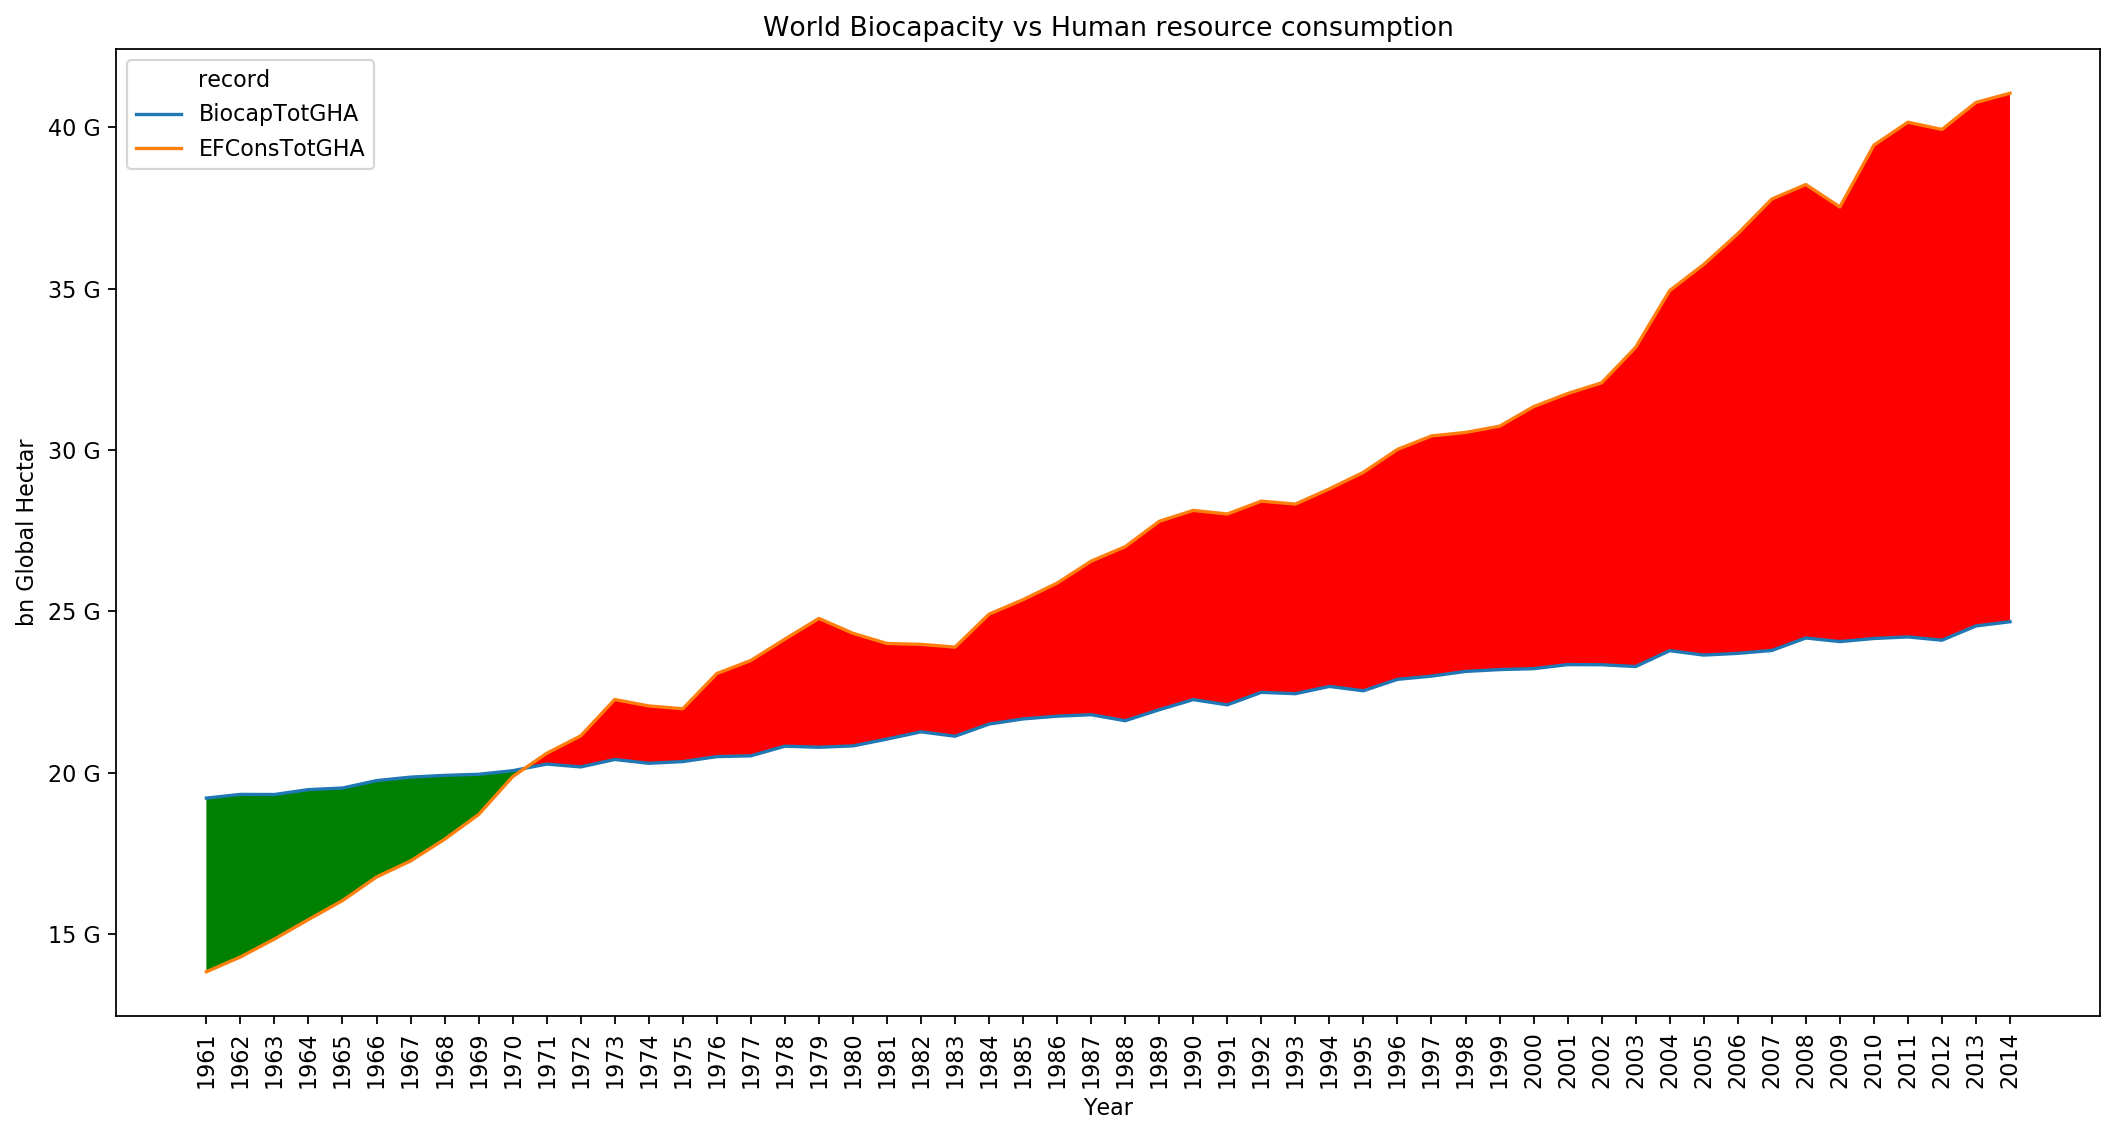

In [31]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=160)

x = nfa_test['year']
y = nfa_test['Biocapacity']
y2 = nfa_test['Ecological Footprint']

#ax = nfa_test.plot(kind='line', x='year')
ax = sns.lineplot(data = nfa_year, x='year',y='total',err_style='bars', hue='record')

ax.fill_between(x, y, y2, where=y >= y2, facecolor='green', interpolate=True)
ax.fill_between(x, y, y2, where=y <= y2, facecolor='red', interpolate=True)
ax.set_title("World Biocapacity vs Human resource consumption")
ax.yaxis.set_major_formatter(FuncFormatter(y_fmt))
ax.set_xlabel('Year')
ax.set_ylabel('bn Global Hectar')

plt.xticks(rotation=90)
;

**Calculating a timeline how many countries were in a deficit per year**

In [32]:
filter_list = ['BiocapTotGHA','EFConsTotGHA']

nfa_year_country = nfa[nfa.record.isin(filter_list)].groupby(['year','country','ISO alpha-3 code','record','population']).total.sum().reset_index()
nfa_year_country.rename(columns={'ISO alpha-3 code':'country_code'},inplace=True)
nfa_year_country = pd.pivot_table(nfa_year_country, values = 'total', index=['year','country_code','country','population'], columns = 'record').reset_index()
nfa_year_country['delta'] = nfa_year_country['BiocapTotGHA'] - nfa_year_country['EFConsTotGHA']
nfa_year_country.head()

record,year,country_code,country,population,BiocapTotGHA,EFConsTotGHA,delta
0,1961,AFG,Afghanistan,9165000,1.213033e+07,1.110278e+07,1.027550e+06
1,1961,AGO,Angola,5367000,5.297725e+07,4.690555e+06,4.828669e+07
2,1961,ALB,Albania,1686000,2.764542e+06,3.239629e+06,-4.750870e+05
3,1961,ARG,Argentina,20953000,2.179637e+08,7.913587e+07,1.388278e+08
4,1961,AUS,Australia,10495000,3.063679e+08,7.840639e+07,2.279615e+08


In [33]:
nfa_year_country['non_overshoot'] = nfa_year_country.delta.apply(lambda x: 1 if x >= 0 else 0)
nfa_year_country['overshoot'] = nfa_year_country.delta.apply(lambda x: 0 if x >= 0 else 1)
nfa_year_country['overshoot_rel'] = (nfa_year_country['BiocapTotGHA'] - nfa_year_country['EFConsTotGHA'])  / (nfa_year_country['BiocapTotGHA'])                                                                                                            
nfa_year_country['overshoot_rel_cap'] = nfa_year_country['delta'] / nfa_year_country['population'] 

<Figure size 2560x1280 with 0 Axes>

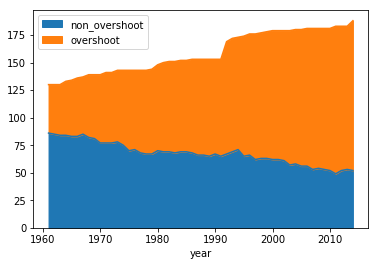

In [34]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 8), dpi=160)

nfa_year_country.groupby('year').agg({'non_overshoot':'sum','overshoot':'sum'}).plot(kind='area')
plt.show;

**Creating a world map of ecological deficits and reserves with timelaps**

In [35]:
url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['ne_110m_admin_0_countries.dbf', 'ne_110m_admin_0_countries.prj', 'ne_110m_admin_0_countries.shp', 'ne_110m_admin_0_countries.shx']


In [36]:
dbf, prj, shp, shx = [filename for filename in filenames]
gdf = gpd.read_file(local_path + shp)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()
print("Shape of the dataframe: {}".format(gdf.shape))
print("Projection of dataframe: {}".format(gdf.crs))
gdf.tail() #last 5 records in dataframe


Shape of the dataframe: (177, 3)
Projection of dataframe: {'init': 'epsg:4326'}


,country,country_code,geometry
172,Republic of Serbia,SRB,"POLYGON ((18.82982479287395 45.90887235802528,..."
173,Montenegro,MNE,"POLYGON ((20.07070000000004 42.58863000000008,..."
174,Kosovo,KOS,"POLYGON ((20.59024654668023 41.85540891928363,..."
175,Trinidad and Tobago,TTO,"POLYGON ((-61.68000000000001 10.76, -61.105 10..."
176,South Sudan,SDS,"POLYGON ((30.83385242171543 3.509171604222463,..."


In [37]:
#print(gdf[gdf['country'] == 'Antarctica'])
#gdf = gdf.drop(gdf.index[159])

In [38]:
gdf.drop('country',axis=1,inplace=True)

In [39]:
df_2014 = nfa_year_country[nfa_year_country['year'] == 2014]

In [40]:
merged = gdf.merge(df_2014, left_on = 'country_code', right_on = 'country_code')
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [41]:
df_2014 = df_2014[['country','country_code','overshoot_rel','overshoot_rel_cap']].reset_index()

In [42]:
#from urllib.request import urlopen
#import json
#with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#    counties = json.load(response)

#import pandas as pd
#df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                   dtype={"fips": str})

#import plotly.express as px

#fig = px.choropleth_mapbox(df_2014, geojson= json_data, locations='country', color='overshoot_rel',
#                           color_continuous_scale="Viridis",
#                           range_color=(0, 1),
#                           mapbox_style="carto-positron",
#                           zoom=3,
#                           opacity=0.5,
#                           labels={'overshoot_rel':'Deficit/Reserve'}
#                          )
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()


In [43]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['RdYlGn'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -5, high = 5)
#Define custom tick labels for color bar.
#tick_labels = np.arrange()
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')#, major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Overshooters and Undershooters relatively to their biocapacity in 2014', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'overshoot_rel', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

**Creating a heatmap per capita**

In [45]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['RdYlGn'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = -5, high = 5)
#Define custom tick labels for color bar.
#tick_labels = np.arrange()
#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')#, major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Overshooters and Undershooters per capita in 2014', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'overshoot_rel_cap', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

**Loading UN_Data**

In [ ]:
df = pd.read_csv('un_data.csv')
df.head()

**Dropping unnecessary columns, pivoting and melting the dataset**<br><br>
In order to get a tidy dataset data is cleaned and re-shaped in a way that:
>each variable is a column

>each observation is a row

>each type of observational unit is a table


In [ ]:
df.drop(['Indicator_Code','Unnamed: 0','Unnamed:_64'], axis=1, inplace=True)

In [ ]:
df.Indicator_Name.nunique()

In [ ]:
df.Indicator_Name.unique()

In [ ]:
cols  = list(df.iloc[:,3:].columns)

In [ ]:
df['Year'] = np.nan

In [ ]:
df.iloc[:,:3].columns

In [ ]:
df.query('Country_Name == "Germany"').Year.unique()

In [ ]:
df = df.melt(id_vars=['Country_Name','Country_Code','Indicator_Name'], var_name='Year', value_name='Value')

In [ ]:
df.head()

In [ ]:
#df_test = pd.pivot_table(df, values = 'Value', index=['Country_Name','Country_Code','Year'], columns = 'Indicator_Name').sort_values(by=['Country_Name','Year']).reset_index()